<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Outbreak_Detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download the packages if not already available
packages_needed <- c("surveillance", "forecast")
packages_to_install <- packages_needed[!(packages_needed %in% installed.packages()[,"Package"])]

if(length(packages_to_install)) {
  install.packages(packages_to_install)
}
lapply(packages_needed, library, character.only = TRUE)

Loading required package: sp

Loading required package: xtable

This is surveillance 1.24.1; see ‘package?surveillance’ or
https://surveillance.R-Forge.R-project.org/ for an overview.

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:surveillance’:

    ses




[[1]]
 [1] "surveillance" "xtable"       "sp"           "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[2]]
 [1] "forecast"     "surveillance" "xtable"       "sp"           "stats"       
 [6] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[11] "base"

In [2]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(readr)
library(purrr)

library(surveillance)  # For Farrington & EARS
library(forecast)      # For ARIMA


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Make R in Colab works with Drive
This setting allows me to replicate the "mount Google Drive" functionality from Python in Colab, since R in Colab also provides a built-in way to access Google Drive.

Ref:
https://colab.research.google.com/drive/1nXsie313OuXjIZMsSOnJULcUpwecsRB-

In [3]:
if (file.exists("/usr/local/lib/python3.6/dist-packages/google/colab/_ipython.py")) {
  install.packages("R.utils")
  library(R.utils)
  library(httr)
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
}

In [4]:
packages <- c("googledrive", "googlesheets4")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())))
}

In [5]:
library(googledrive)
library(googlesheets4)


Attaching package: ‘googlesheets4’


The following objects are masked from ‘package:googledrive’:

    request_generate, request_make




In [6]:
# Save cache in a file so that i don't have to authenticate repeatedly
drive_auth(cache = "/content/drive/My Drive/.secrets", use_oob = TRUE)

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: nadillia.sahputra@isi.it


Selection: 2


# Read Data

In [7]:
path <- "simulation_data(grid-2000 days).csv"
drive_download(file = paste0("simulation/", path), path = path, overwrite = TRUE)

data <- read_csv(path)
data <- data %>% rename(True_Outbreak = "True Outbreak")
data <- data %>% rename(Reported_Cases = "Reported Cases")
data$Population <- data$Susceptible + data$Infected + data$Recovered
data$Region <- data$Region + 1 #Convert from (0 - 2) to (1 - 3) due to R indexing
tail(data)

File downloaded:

• simulation_data(grid-2000 days).csv <id: 1-524jCvNNs4fwHdaBiSlx6ZUbSfXPQvq>

Saved locally as:

• simulation_data(grid-2000 days).csv

Rows: 50000 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): Day, Region, Susceptible, Infected, Recovered, Reported Cases, True...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Day,Region,Susceptible,Infected,Recovered,Reported_Cases,True_Outbreak,Population
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1994,25,372,169,455,22,1,996
1995,25,371,166,434,4,1,971
1996,25,344,173,434,14,1,951
1997,25,335,169,444,7,1,948
1998,25,353,177,429,9,1,959
1999,25,350,167,444,5,1,961


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


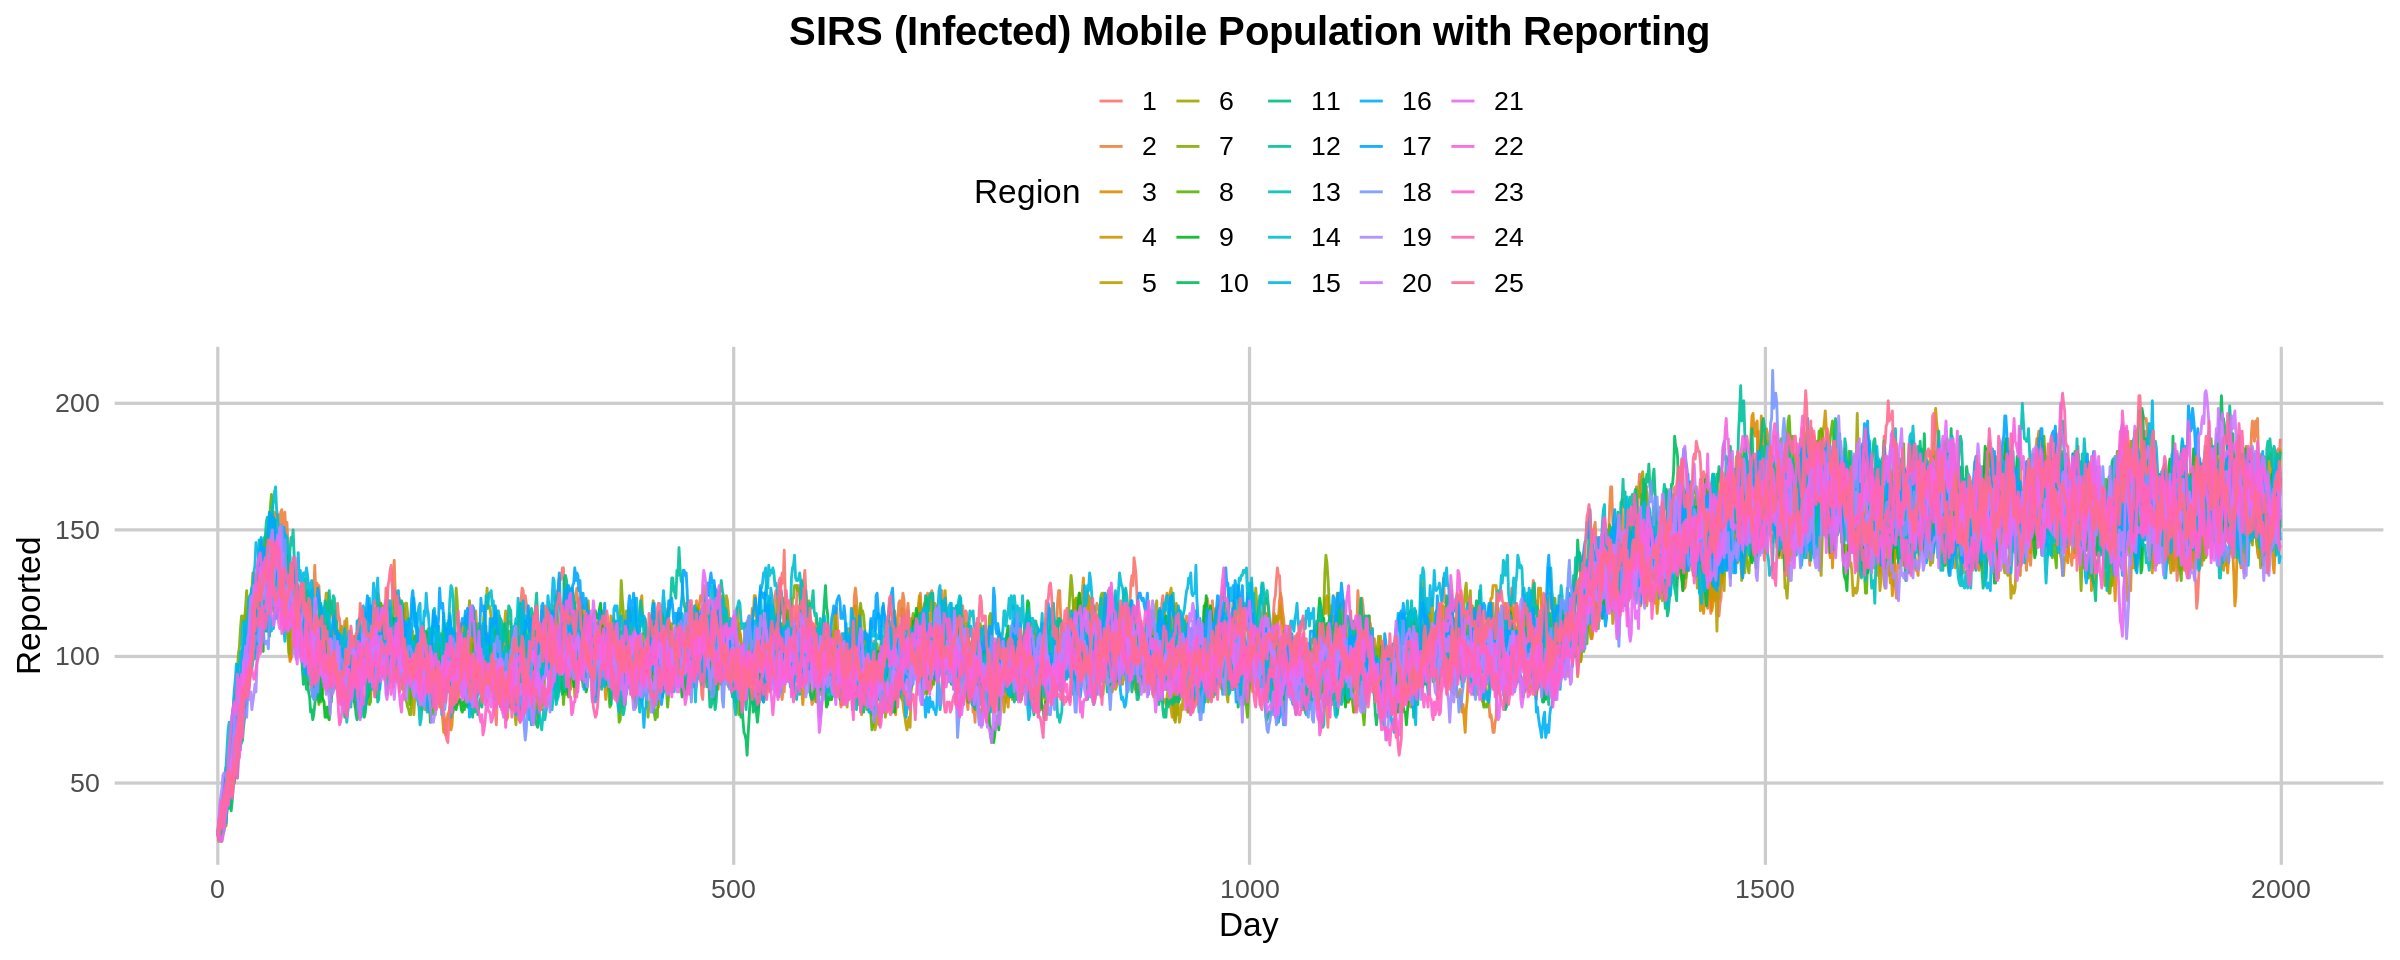

In [8]:
# PLot to determine the inital period that I want to discard
# Here I plot the number of infected of all the regions because the infected graph is less messy (more readable) and I could make sure that all the regions have similar behaviour
options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(data, aes(x = Day, y = Infected, color = factor(Region))) +
  geom_line(size = 0.8, alpha = 0.9) +
  labs(
    title = "SIRS (Infected) Mobile Population with Reporting",
    x     = "Day",
    y     = "Reported",
    color = "Region"
  ) +
  theme_minimal(base_size = 20) +
  theme(
    panel.grid.major  = element_line(color = "grey80"),
    panel.grid.minor  = element_blank(),
    plot.title        = element_text(face = "bold", hjust = 0.5),
    legend.position   = "top"
  )


In [9]:
burn_in <- 252 # Discard the initial 250 days
data_processed <- data %>% filter(Day > burn_in) # "data_processed" is the name of dataset that i will use to process from now-n

# Summarise when the outbreak starts and end (mostly for plotting purposes)
outbreak_periods <- data_processed %>%
  arrange(Day) %>%
  mutate(
    start_flag = (True_Outbreak == 1) & (lag(True_Outbreak, default = 0) == 0), # Start day must be when the day now has label 1 and yesterday 0
    end_flag   = (True_Outbreak == 0) & (lag(True_Outbreak, default = 1) == 1)  # End day must be when the day now has label 0 and yesterday 1
  ) %>%
  mutate(group = cumsum(start_flag)) %>%
  filter(True_Outbreak == 1) %>%
  group_by(group) %>%
  summarise(
    start = min(Day),
    end   = max(Day)
  )

In [10]:
## Aggregate to "world level" and weekly instead of daily
t1 <- 1270 # Need to be fixed later so that it is automatic detection

## Make Into Weekly Data
data_rounded <- data_processed %>% filter(Day <= max(Day) - (max(Day) %% 7))  # In case, the number of days is not rounded to make it weekly, cut off the last days

data_world <- data_rounded %>%
  group_by(Week = floor((Day - 1) / 7) + 1) %>%
  summarise(
    Reported_Cases = sum(Reported_Cases),
    First_Day = min(Day),
    Last_Day = max(Day),
    .groups = "drop"
  ) %>%
  # Label as outbreak if any day in the week is ≥ t1
  mutate(True_Outbreak = as.integer(Last_Day >= t1))


outbreak_world <- outbreak_periods %>%
  mutate(start = floor((start - 1) / 7) + 1,
         end = floor((end - 1) / 7) + 1) %>%
  distinct(start, end)

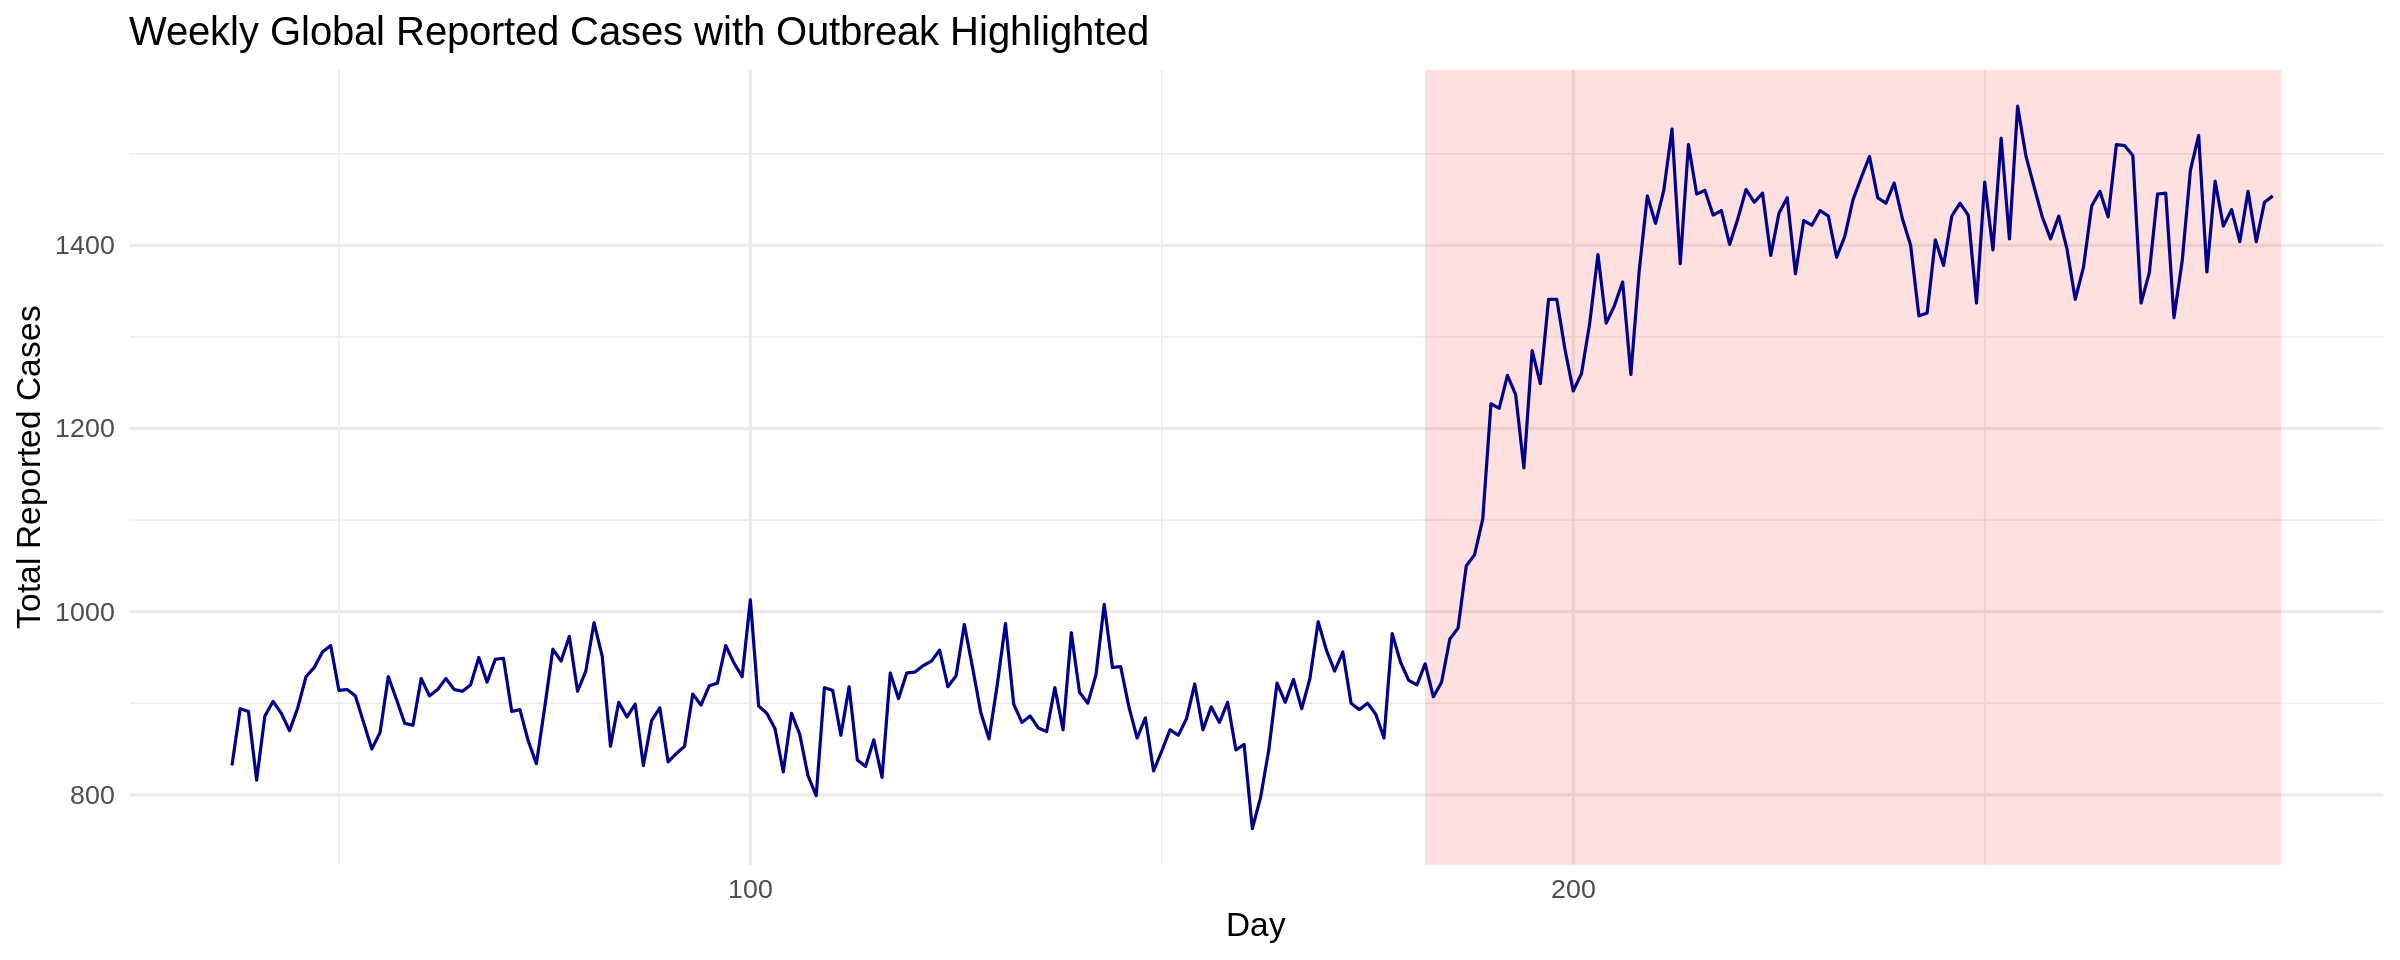

In [11]:
ggplot(data_world, aes(x = Week, y = Reported_Cases)) +
  geom_rect(
    data = outbreak_world,
    aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
    fill = "red", alpha = 0.12, inherit.aes = FALSE
  ) +
  geom_line(color = "darkblue", size = 0.9) +
  labs(
    title = "Weekly Global Reported Cases with Outbreak Highlighted",
    x = "Day",
    y = "Total Reported Cases"
  ) +
  theme_minimal(base_size = 20)


# **Detection Functions (Farrington Flexible, EARS, ARIMA)**

In [12]:
detect_farrington_flex <- function(df, b = 1, w = 1, noPeriods = 1, pastWeeksNotIncluded = 0, trend = FALSE) {

  # Create the sts object
  sts_week <- sts(observed = df$Reported_Cases, freq = 1)

  # Run Farrington Flexible
  farr_week <- farringtonFlexible(
    sts_week,
    control = list(
      b = b, w = w, noPeriods = noPeriods,
      pastWeeksNotIncluded = pastWeeksNotIncluded,
      trend = trend,
      alpha = 0.05
    )
  )

  # Just taking the variable to match the week with the alarm
  n_result <- length(observed(farr_week))
  max_week <- max(df$Week)

  # Store the "forecast" values
  forecast_df <- tibble::tibble(
    target_week = (max_week - n_result + 1):max_week,
    actual_value = observed(farr_week),
    upper_bound = upperbound(farr_week),
    Alarm = as.numeric(alarms(farr_week) > 0)
  )

  return(list(signal = forecast_df$Alarm, forecast = forecast_df))
}


In [13]:
# EARS detection
detect_ears <- function(df, method = "C3", baseline = 100) {
  # Convert to sts object
  sts_cases <- sts(observed = df$Reported_Cases, freq = 1)
  # EARS with the method can be C1/C2/C3 and baseline is the temporal window
  ears <- earsC(sts_cases, control = list(method = method, baseline = baseline))

  # Just taking the variable to match the week with the alarm
  n_result <- length(observed(ears))
  max_week <- max(df$Week)

  # Store the "forecast" values
  forecast_df <- tibble::tibble(
    target_week = (max_week - n_result + 1):max_week,
    actual_value = observed(ears),
    upper_bound = upperbound(ears),
    Alarm = as.numeric(alarms(ears) > 0)
  )

  return(list(signal = forecast_df$Alarm, forecast = forecast_df))
}


In [14]:
# ARIMA detection
detect_arima <- function(df, window_size = 100, interval = 0.95, jump = 1) {
  # Parameters:
  # df = input data
  # window_size = initial training size (burn-in)
  # interval = confidence level for prediction interval (e.g., 0.95)
  # jump = number of days to move the forecast window forward

  n <- nrow(df)  # Total number of timepoints
  arima_signal <- rep(0, n)  # Initialize outbreak signal (0 = no alarm)
  forecast_records <- list()  # List to store forecast info

  t <- window_size + 1  # Start detection after initial training window

  while (t <= n) {
    start_day <- 1  # Expanding window always starts from day 1
    train_data <- df$Reported_Cases[start_day:(t - 1)] # Train data since day one untill yesterday/last week to get the predicted now

    # Fit ARIMA model on training data
    arima_fit <- auto.arima(train_data)

    # Forecast next few days (up to jump days or until end)
    h <- min(jump, n - t + 1)
    preds <- forecast(arima_fit, h = h, level = interval * 100)

    # Extract upper bounds and means
    uppers <- preds$upper[, 1]
    lowers <- preds$lower[, 1]
    means <- preds$mean

    # Loop through forecast horizon
    for (j in 0:(h - 1)) {
      tt <- t + j  # Actual index in data
      if (tt > n) break

      actual_value <- df$Reported_Cases[tt]

      # I want to safe the forecast results
      forecast_records[[length(forecast_records) + 1]] <-  tibble::tibble(
        forecast_week = df$Week[t],
        target_week = df$Week[tt],
        forecast_mean = means[j + 1],
        upper_bound = uppers[j + 1],
        lower_bound = lowers[j + 1],
        # These two information below is just for cross-checking with the original data
        actual_value = actual_value,
        label = df$True_Outbreak[tt]
      )

      # Raise alarm if actual value exceeds prediction upper bound
      if (actual_value > uppers[j + 1]) {
        arima_signal[tt] <- 1
      }
    }

    t <- t + jump  # Move the forecasting step forward
  }

  # Construct forecast data frame and trim signal to post-burn-in
  forecast_df <- do.call(rbind, forecast_records)
  arima_signal_trimmed <- arima_signal[(window_size + 1):n]

  return(list(
    signal = arima_signal_trimmed,
    forecast_df = forecast_df
  ))
}


# **Evaluation Metrics Functions (Sensitivity, Specificity, Precision, Timeliness)**

In [15]:
# This function compute timeliness based on the idea/approach/equation from this following paper
# https://academic.oup.com/bioinformatics/article/35/17/3110/5301313

# I will come back to this function again, because as of now I am not yet satisfied with this
compute_timeliness <- function(true_labels, detected_labels) {
  # Find outbreaks
  outbreaks <- which(true_labels == 1)
  if (length(outbreaks) == 0) return(NA) # If there is no outbreaks, return NA

  # Group contiguous outbreak days
  diff_outbreaks <- c(Inf, diff(outbreaks)) # Calculate the difference of the days when outbreak happened
  new_outbreak_starts <- which(diff_outbreaks > 1) # If the difference is more than 1 then there is the new outbreak
  outbreak_groups <- split(outbreaks, cumsum(c(1, diff_outbreaks[-1] > 1))) # Split into groups of outbreaks

  # Compute timeliness for each outbreak
  delays <- sapply(outbreak_groups, function(group) {
    alarms_in_period <- which(detected_labels[group] == 1) # Get the outbreak grouping on the detected data
    if (length(alarms_in_period) > 0) { # If there is an outbreak detected,
      delay <- alarms_in_period[1] - 1  # take the day when it is first detected and calculate the delat
      delay / length(group)             # normalized with the length/duration of the outbreak
    } else {
      1  # worst score if never detected
    }
  })

  return(mean(delays)) # Take the mean over all the outbreak periods
}

In [16]:
metrics <- function(true, detected) {
  # This function calculates the evalutation metrics Sensitivity, Specificity, Precision
  TP <- sum(true == 1 & detected == 1)
  FP <- sum(true == 0 & detected == 1)
  TN <- sum(true == 0 & detected == 0)
  FN <- sum(true == 1 & detected == 0)
  Sensitivity <- ifelse((TP+FN)==0, NA, TP/(TP+FN))
  Specificity <- ifelse((TN+FP)==0, NA, TN/(TN+FP))
  Precision   <- ifelse((TP+FP)==0, NA, TP/(TP+FP))
  Timeliness  <- compute_timeliness(true, detected)
  return(list(Sensitivity=Sensitivity, Specificity=Specificity, Precision=Precision, Timeliness=Timeliness))
}

# **Run The Analysis**

In [17]:
analyze_region <- function(df, true_label_col = "True_Outbreak", detectors, region_id = NULL) {
# This function runs the input data through all specified outbreak detection methods,
# then calculates the evaluation metrics and outputs both the detection signals and their corresponding metrics.

  # Run all detectors, collect signals as a named list
  detector_outputs <- lapply(detectors, function(f) f(df))

  signals_list <- lapply(detector_outputs, function(x) x$signal)
  names(signals_list) <- names(detectors)


  # Not all the detectors give the same signal length.
  # Therefore, find the minimum length to align all signals and labels
  true_label <- df[[true_label_col]]
  all_lengths <- c(length(true_label), sapply(signals_list, length))
  min_len <- min(all_lengths)

  # and trim everything
  true_label_cut <- tail(true_label, min_len)
  signals_cut <- lapply(signals_list, tail, min_len)

  forecast_list <- lapply(detector_outputs, function(x) tail(x$forecast, min_len))
  names(forecast_list) <- names(detectors)

  # Compute metrics for each method, using the trimmed signal
  metrics_list <- mapply(function(method, signal) {
    m <- metrics(true_label_cut, signal)
    tibble::tibble(
      Region = region_id,
      Method = method,
      Sensitivity = m$Sensitivity,
      Specificity = m$Specificity,
      Precision = m$Precision,
      Timeliness = m$Timeliness
    )
  }, method = names(signals_cut), signal = signals_cut, SIMPLIFY = FALSE)

  metrics_df <- dplyr::bind_rows(metrics_list)

  # Make metrics and aligned signals as output
  signals_df <- data.frame(Week = tail(df$Week, min_len),
                           True.Label = true_label_cut,
                           signals_cut)

  return(list(metrics = metrics_df, signals = signals_df, forecasts = forecast_list))
}


In [18]:
detectors <- list(
  Farrington_Flexible = detect_farrington_flex,
  EARS = detect_ears,
  ARIMA = detect_arima
)

In [19]:
# Apply detection analysis on the global data
global_result <- analyze_region(data_world, true_label_col = "True_Outbreak", detectors, region_id = "Global")

# View metrics
global_result$metrics

Region,Method,Sensitivity,Specificity,Precision,Timeliness
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Global,Farrington_Flexible,0.1250000,0.8780488,0.7222222,0.02884615
Global,EARS,0.3173077,1.0000000,1.0000000,0.05769231
Global,ARIMA,0.1153846,0.9268293,0.8000000,0.04807692


# **Plotting**

In [20]:
# Function for plotting
plot_detector_forecast <- function(result, detector_name = "ARIMA") {
  forecast_df <- result$forecasts[[detector_name]]

  # Band aid method because the output from different detection methods are not the same (to be fixed)
  # If Alarm column in forecast tibble doesn't exist, join it from the signals data
  if (!"Alarm" %in% names(forecast_df)) {
    signal_df <- result$signals %>%
      select(Week, Alarm = all_of(detector_name))

    forecast_df <- forecast_df %>%
      left_join(signal_df, by = c("target_week" = "Week"))
  }

  p <- ggplot(forecast_df, aes(x = target_week))

  # Add the outbreak period visualization (red block)
  p <- p + geom_rect(
    data = outbreak_world,
    aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
    fill = "red", alpha = 0.12, inherit.aes = FALSE
  )


  # If there is a column named "lower bound", then make a prediction range plot (ribbon)
  if ("lower_bound" %in% names(forecast_df) && "upper_bound" %in% names(forecast_df)) {
    p <- p + geom_ribbon(aes(ymin = lower_bound, ymax = upper_bound, fill = "Prediction Interval"), alpha = 1)
  } else if ("upper_bound" %in% names(forecast_df)) { # If no "lower bound", then just plot upper bound (threshold)
    p <- p + geom_line(aes(y = upper_bound, color = "Upper Bound (Threshold)"), size = 1, linetype = "dashed")
  }

  # Plot the reported cases
  p <- p +
    geom_line(aes(y = actual_value, color = "Actual"), size = 1)

  # Alarms are reprented as a dot
  p <- p + geom_point(data = filter(forecast_df, Alarm == 1),
                        aes(y = actual_value, color = "Alarm"), size = 2.5)

  p <- p +
    scale_color_manual(name = "Legend",
                       values = c("Actual" = "black", "Alarm" = "red", "Upper Bound (Threshold)" = "blue")) +
    scale_fill_manual(name = "Legend", values = c("Prediction Interval" = "lightblue")) +
    labs(title = paste("Weekly Outbreak Detection with", detector_name),
         x = "Week", y = "Reported Cases") +
    theme_minimal(base_size = 20) +
    theme(legend.position = "top")

  return(p)
}

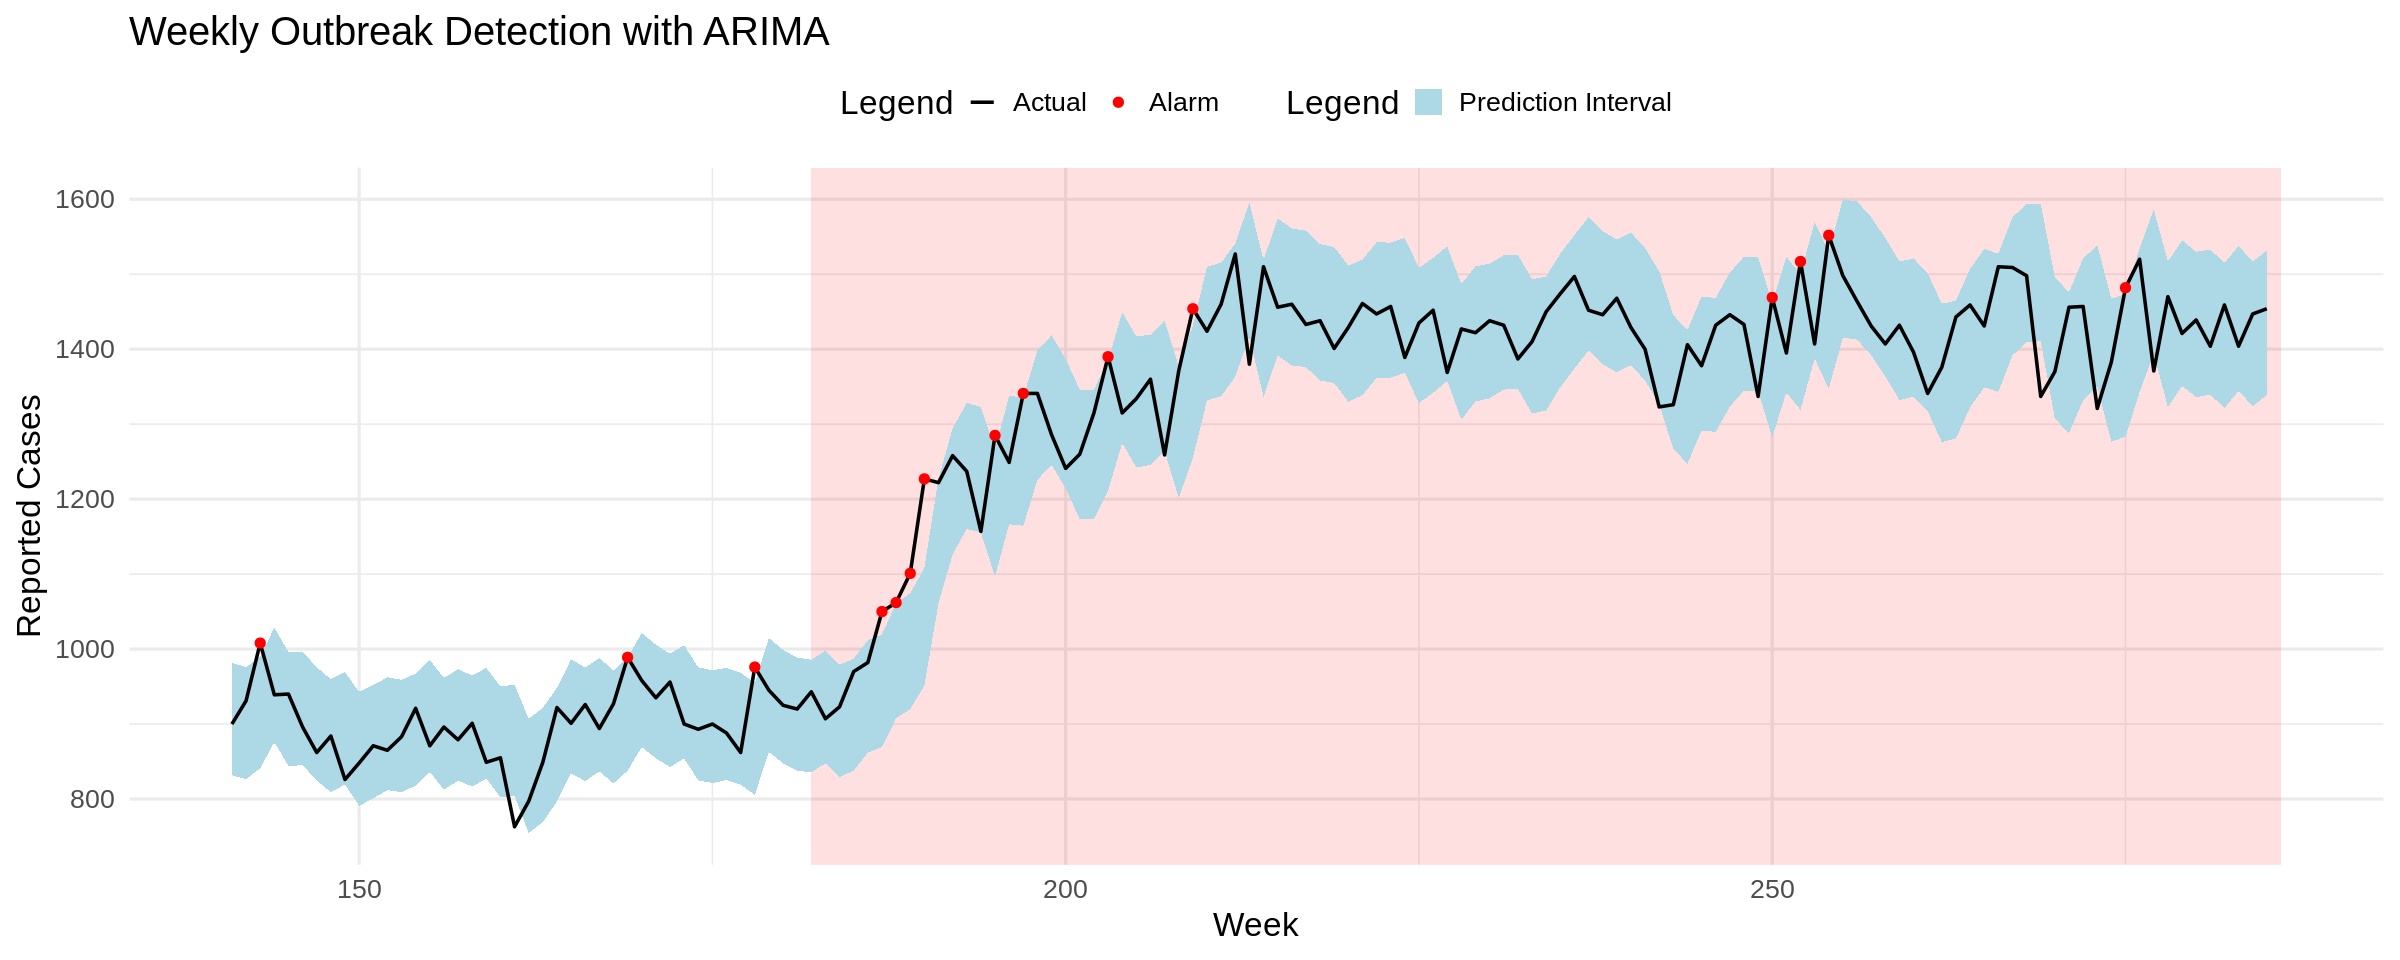

In [21]:
plot_detector_forecast(global_result, "ARIMA")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


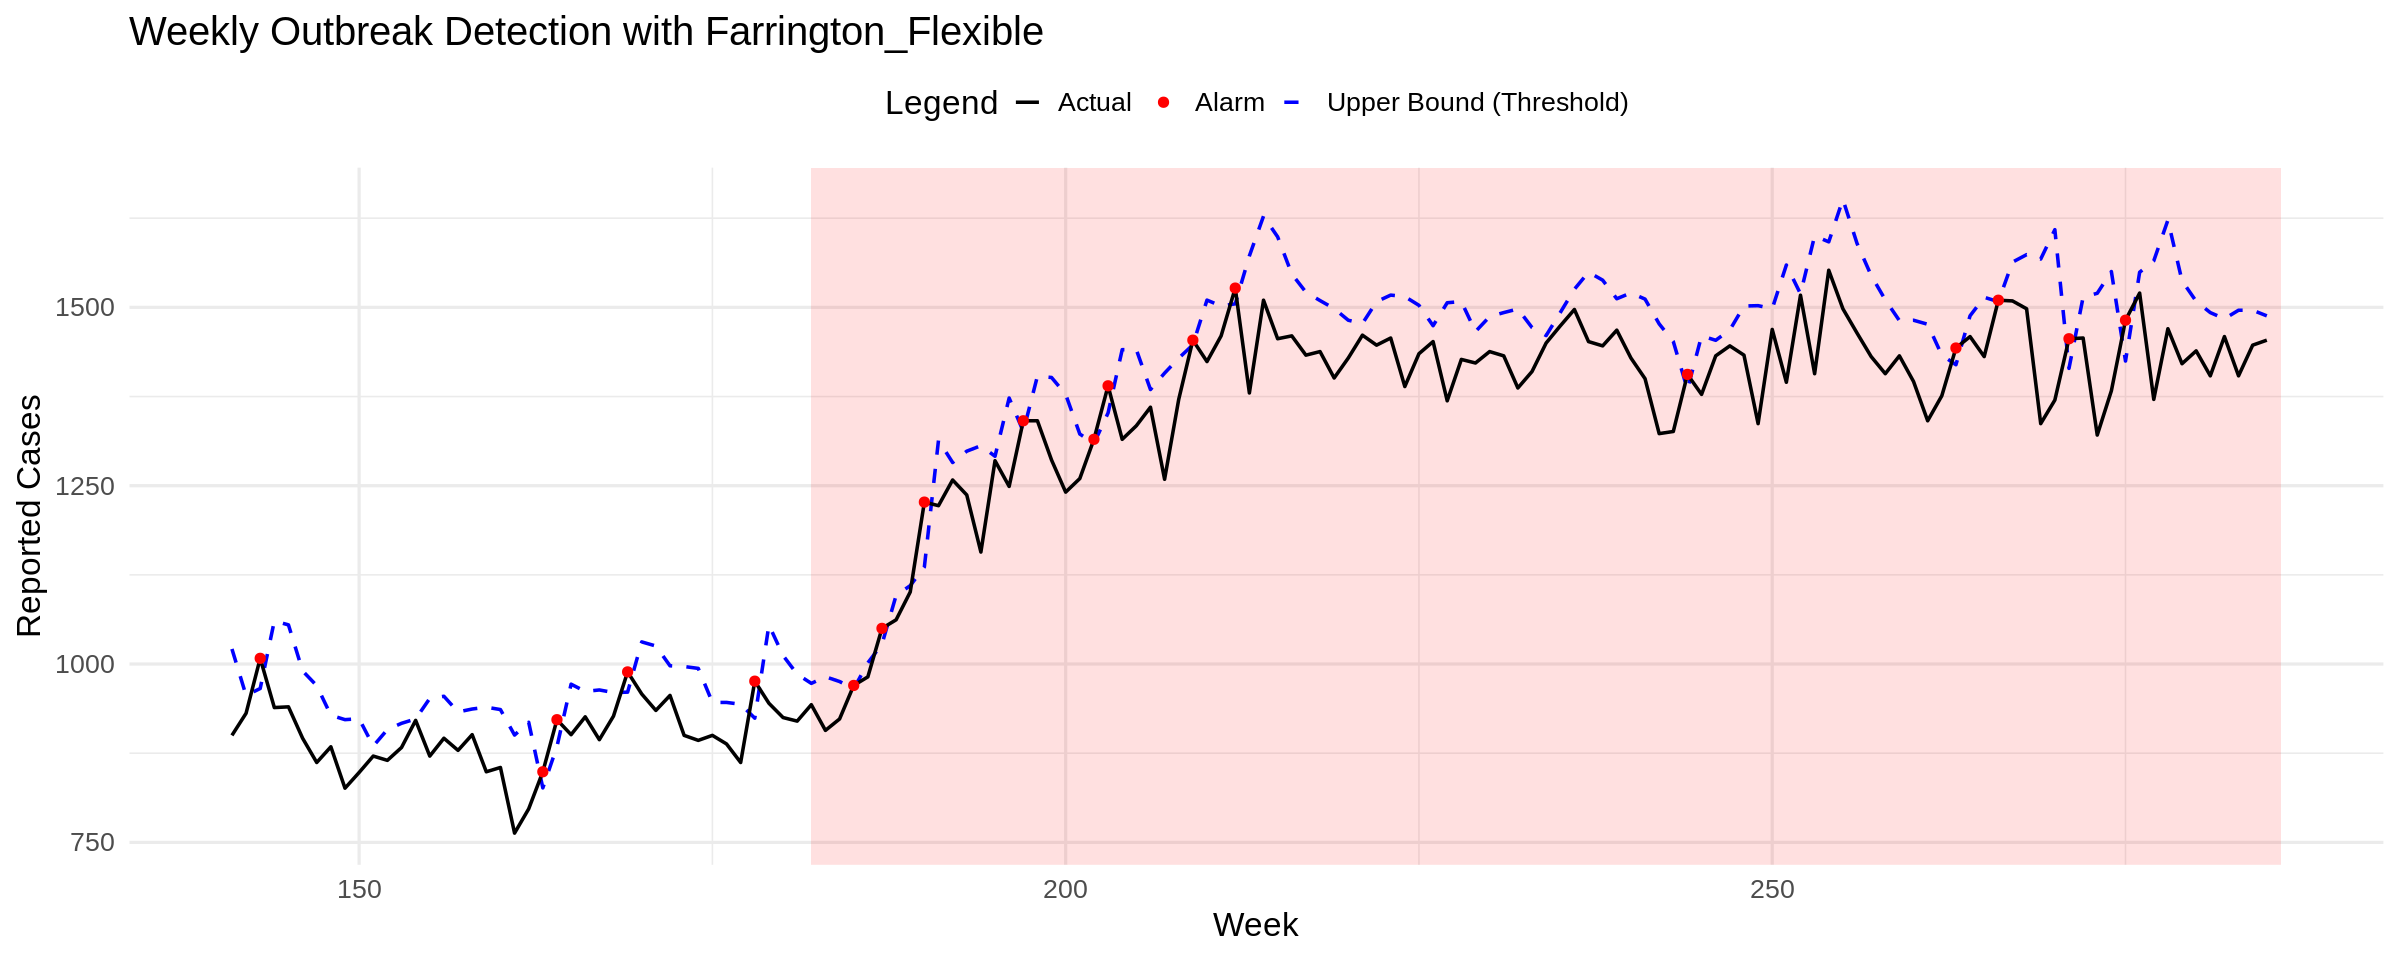

In [22]:
plot_detector_forecast(global_result, "Farrington_Flexible")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


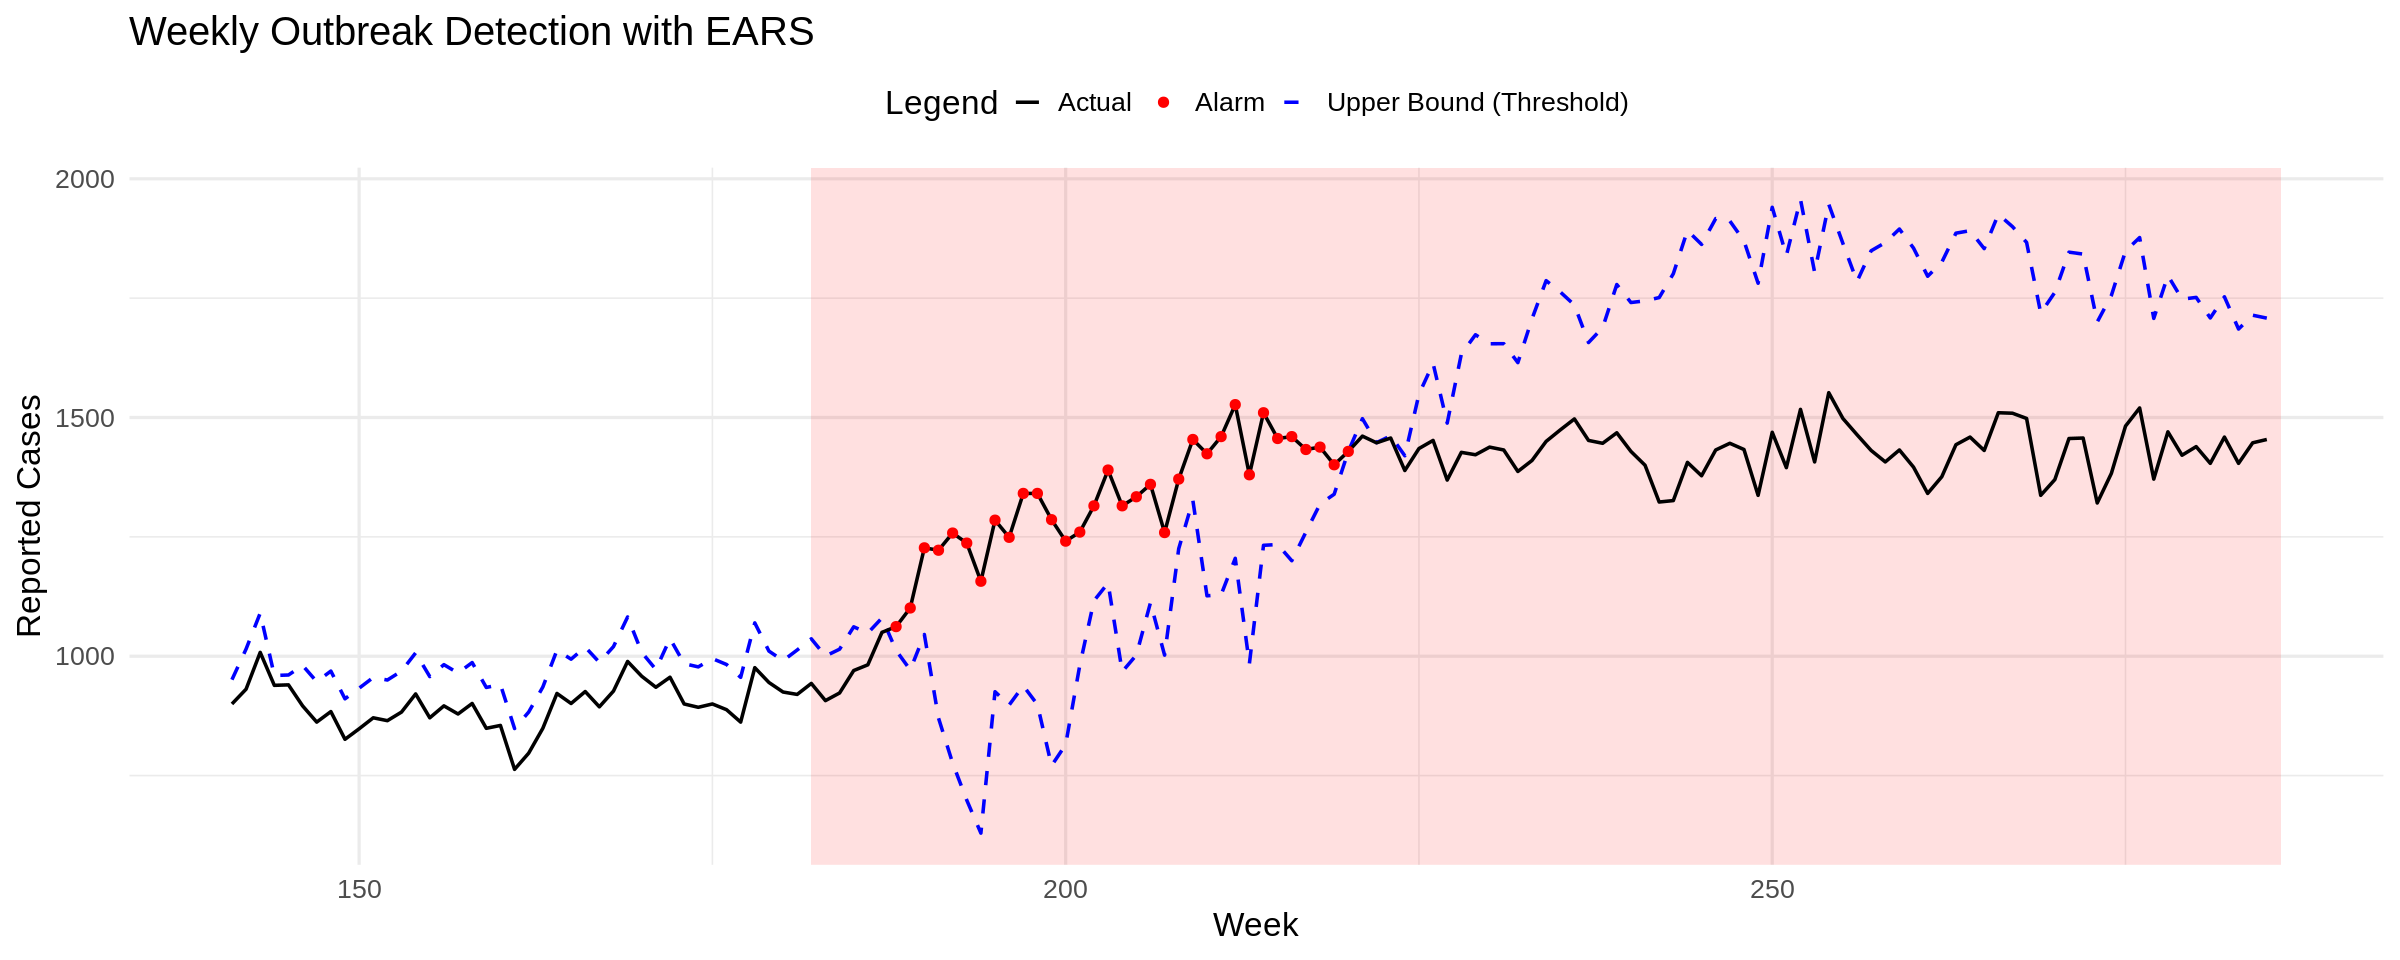

In [23]:
plot_detector_forecast(global_result, "EARS")